## Factors influencing the dissociation of cells after exposure to a force
Podemos expressar a variação do número de ligações como:
$$
\frac{d N_C}{dt} = k_{1}(N_{L_0} - N_C)(N_{R_0} - N_C) - k_{-1}^{0} \exp \left(\frac{x_a F}{k_b T N_C} \right) N_C
$$

considerando os parâmetros admensionais:
$$\tau = k_{1} N_{L_0} t$$
$$\kappa = \frac{K_{D}^{0}}{N_{L_0}}$$
$$\alpha = \frac{x_a F}{k_b T N_{R_0}}$$
$$\theta = \frac{N_C}{N_{R_0}}$$

escrevemos a EDO como:
$$
\frac{d \theta}{d \tau} = 1 - \theta - \kappa \theta \exp \left(\frac{\alpha}{\theta}\right)
$$

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from graph_style import apply_authentic_seaborn_style as style_gustavo

In [ ]:
def solve_rk4(f, t_span, y0, h, *args):
    """
    Resolve um sistema de EDOs usando o método RK4 de passo fixo.
    f: função da derivada, f(t, y, *args)
    t_span: [t_inicial, t_final]
    y0: condições iniciais
    h: tamanho do passo
    *args: argumentos extras para a função f
    """
    y0 = np.asarray(y0)
    num_steps = int((t_span[1] - t_span[0]) / h)
    time_points = np.linspace(t_span[0], t_span[1], num_steps + 1)
    y_results = np.zeros((num_steps + 1, len(y0)))
    y_results[0] = y0
    
    for i in range(num_steps):
        t_i = time_points[i]
        y_i = y_results[i]
        
        k1 = f(t_i, y_i, *args)
        k2 = f(t_i + h/2, y_i + h * k1/2, *args)
        k3 = f(t_i + h/2, y_i + h * k2/2, *args)
        k4 = f(t_i + h, y_i + h * k3, *args)
        
        y_next = y_i + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
        y_results[i+1] = y_next
        
    return time_points, y_results

In [ ]:
def dtheta_dtau(t, y, alpha, kappa):
    """
    Função da EDO (Eq. 12.3.20) adaptada para o solver.
    """
    theta = y[0]
    
    if theta <= 0:
        return np.array([0.0])
    
    try:
        exp_term = np.exp(alpha / theta)
    except OverflowError:
        exp_term = np.inf
        
    derivative = 1 - theta - kappa * theta * exp_term
    return np.array([derivative])

In [ ]:
# --- Parâmetros da Simulação ---
alpha_values = [0.0, 0.1, 0.25, 0.3, 0.4, 0.5]
kappa_values = [1.2, 1.0, 1.0, 1.0, 1.0, 1.0] 
kappa_initial = 1.0
theta0 = 1 / (1 + kappa_initial)
t_span = [0, 5]
h = 0.01

# --- Rodar a Simulação e Armazenar os Resultados ---
results = []
for alpha, kappa in zip(alpha_values, kappa_values):
    y0 = np.array([theta0])
    
    t_vals, y_results = solve_rk4(
        dtheta_dtau, 
        t_span, 
        y0, 
        h, 
        alpha, 
        kappa
    )
    
    theta_vals = y_results[:, 0]
    
    detach_idx = np.where(theta_vals <= 0.02)[0]
    if len(detach_idx) > 0:
        end_idx = detach_idx[0]
        t_vals = t_vals[:end_idx]
        theta_vals = theta_vals[:end_idx]

    df_temp = pd.DataFrame({
        'Dimensionless Time': t_vals,
        'Fraction of Receptors Bound': theta_vals,
        'alpha': alpha
    })
    results.append(df_temp)

results_df = pd.concat(results, ignore_index=True)

Estilo pessoal Seaborn aplicado com sucesso (Modo Escuro)!


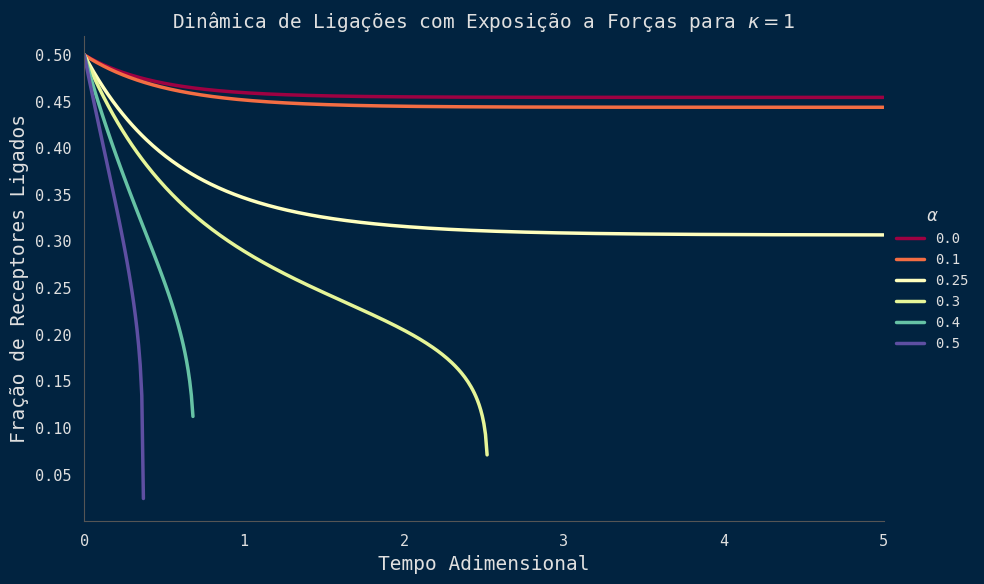

In [28]:
# --- Plotagem com Legenda (Método Seaborn Idiomático) ---
# plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(10, 6))
style_gustavo()
# Uma única chamada ao seaborn.lineplot usando o parâmetro 'hue'.
# Ele cuidará de criar as linhas e a legenda automaticamente.
sns.lineplot(
    data=results_df,
    x='Dimensionless Time',
    y='Fraction of Receptors Bound',
    hue='alpha',
    palette='Spectral',              
    ax=ax
)

# --- Customização do Gráfico ---
ax.set_xlim(0, 5)
ax.set_ylim(0.0, 0.52)
ax.set_xlabel('Tempo Adimensional')            
ax.set_ylabel('Fração de Receptores Ligados')
ax.set_yticks(np.arange(0.05, 0.55, 0.05))
ax.grid(False)
sns.despine()
ax.set_title(r"Dinâmica de Ligações com Exposição a Forças para $\kappa=1$", fontsize=14)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title=r'$\alpha$', loc='center left', bbox_to_anchor=(1, 0.5))

# Ajusta o layout para garantir que a legenda não seja cortada da imagem final
plt.tight_layout()

plt.show()